# Data Preprocessing

## Step1: Import data

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tqdm import tqdm

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

from preprocessing import *
from custom_layers import MFCC, MelSpectrogram
sns.set_context("talk")
# plt.style.use('ggplot')
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-15 22:27:39.367513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_dir = pathlib.Path('data/speech_commands_v0.02')

In [3]:
# Dataset: visualize the folders corresponding to the keywords
core_kws, aux_kws, output_classes = get_kws(data_dir)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Auxiliary keywords:  ['learn', 'happy', 'backward', 'house', 'sheila', 'bird', 'wow', 'dog', 'marvin', 'follow', 'forward', 'bed', 'cat', 'visual', 'tree']


From all those keywords, we will teach our models to learn the core 20, and use the remaining ones to help him detect "filler" keywords. So in total, the output classes of our network will be 21.
Indeed, from the readme file:

*Twenty core command words were recorded, with most speakers saying each
of them five times. The core words are "Yes", "No", "Up", "Down", "Left",
"Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
"Five", "Six", "Seven", "Eight", and "Nine". To help distinguish unrecognized
words, there are also ten auxiliary words, which most speakers only said once.
These include "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila",
"Tree", and "Wow".*

**NB**: It seems that there is an error in this readme file, since there are 5 more auxiliary keywords (*'backward', 'follow', 'forward', 'learn', 'visual'*) in the dataset folder!

In [9]:
filenames = get_filenames(data_dir, core_kws + aux_kws)
print(f"Total number of audio files: {len(filenames)}")

Total number of audio files: 105829


### Class balance

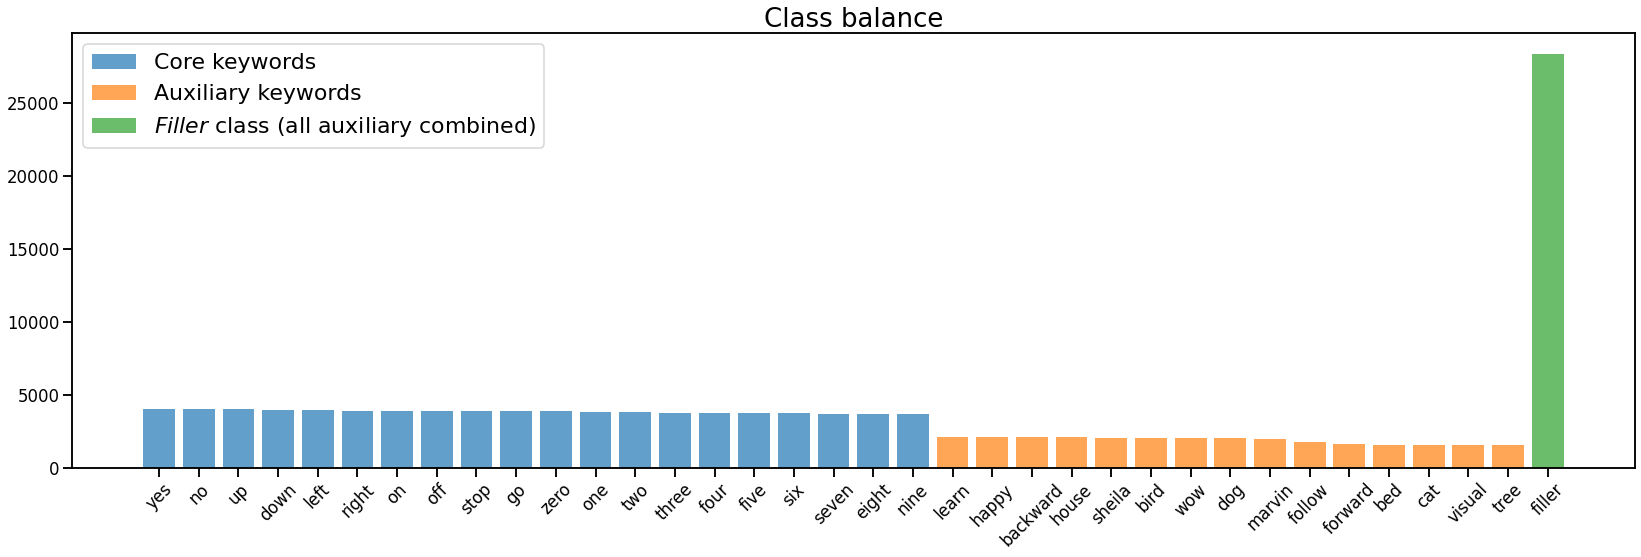

In [6]:
# Let's inspect class balance
core_samples_amt = []
aux_samples_amt = []
for keyword in core_kws:
    n = len(tf.io.gfile.listdir(data_dir/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    core_samples_amt.append(n)
    
    
for keyword in aux_kws:
    n = len(tf.io.gfile.listdir(data_dir/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    aux_samples_amt.append(n)

plt.figure(figsize=(28,8))
plt.bar(core_kws, np.sort(core_samples_amt)[::-1], label="Core keywords", alpha=0.7)
plt.bar(aux_kws, np.sort(aux_samples_amt)[::-1], label="Auxiliary keywords", alpha=0.7)
plt.bar("filler", sum(np.sort(aux_samples_amt)[::-1]), label="$Filler$ class (all auxiliary combined)", alpha=0.7)
plt.legend(fontsize=22)
plt.xticks(rotation=45)
plt.title("Class balance", fontsize=26)
plt.show()

We can see that classes are more or less balanced within core words and within auxiliary words; however, we will combine all the auxiliary words into a single class "filler", therefore such class will be unbalanced with respect to the others.

In [11]:
labels = np.array([get_label_int(file, aux_kws, output_classes) for file in filenames])

## Train-Validation-Test Split

First, we split the whole dataset into Training and Test set, preserving the percentage of samples for each class. Later, we also take a little part out from the Training set to use as a Validation set for training, always keeping in mind the class balance. To do the split we first have to assign labels to each audio file.

## Split into train-validation-test, keeping class balance


In [12]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_train_valid_test_split(filenames, 
                                                                                labels, 
                                                                                train_percentage=0.8,
                                                                               valid_percentage=0.1,
                                                                               test_percentage=0.1,
                                                                               seed=0)

#See size of each created set
print(f"len(X_train) = {len(X_train)}")
print(f"len(X_valid) = {len(X_valid)}")
print(f"len(X_test) = {len(X_test)}")

len(X_train) = 84663
len(X_valid) = 10582
len(X_test) = 10584


In [13]:
#visualize class balance
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
unique_te, counts_te = np.unique(y_test, return_counts=True)

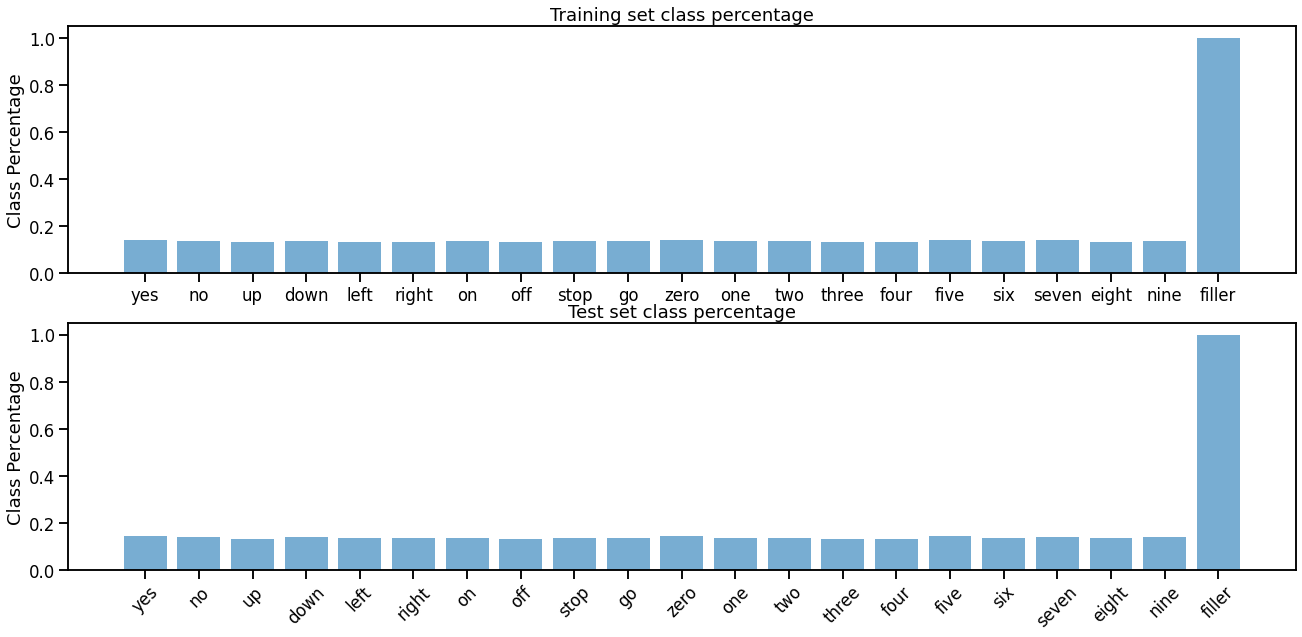

In [14]:
#display same class balance
fig, axes = plt.subplots(2, figsize=(22,10))
axes[0].bar([output_classes[i] for i in  unique_tr], counts_tr/max(counts_tr), alpha=0.6)
axes[1].bar([output_classes[i] for i in  unique_te], counts_te/max(counts_te), alpha=0.6)
axes[0].set_ylabel("Class Percentage")
axes[1].set_ylabel("Class Percentage")
axes[0].set_title("Training set class percentage")
axes[1].set_title("Test set class percentage")
plt.xticks(rotation=45)
plt.show()

## List of preprocessing steps.
We now have a dataset (already split in train, validation and test) which is just a collection of filenames, and their related collection of ground truth labels. We now have to load the actual data. To do that, we define speific functions that for each audio file name produce the actual input features for the NN.
Those are the preprocessing steps, which are as follows:

1) From the file, load the actual sound waveform. It is a time series data normalized in the range [-1,1], and almost all are composed of 16000 samples. Since the sounds' sample rate is 16kHz, they are almost all audio clips of 1 second. We don't need to make zero padding since the actual input for the NN will be crops of fixed size of the feature vectors.

Note that this is the only true Preprocessing step that we will make to our dataset. All the following steps will be implemented as custom layers which will be part of our NN models. This choice was made for several reasons: first, the dataset is too big to fit into the memory of my GPU, so the only choice was to create an efficient input pipeline with a `tf.data.Dataset`, configured to load chunks of data during training (with `dataset.prefetch()`) and using caching (with `dataset.cache()`) to speed things ever more. Even doing so, all the following preprocessing steps were really expensive for the CPU which, at training time, was causing a significant bottleneck. For this reasons, I implemented the following preprocessing steps as custom NN layers, in order to make parallel computations for each batch and eliminating the CPU bottleneck.

2) Create audio frames of $w$ samples, with step size $s$, and for each of them extract the Mel Frequency Cepstral Coefficients from the audio files. This creates a feature vector of dimension $39$ for each audio frame. Main hyperparameters for this step are window length and window step. Additional experiments can be made with different n. of filters.

3) Normalization of features ... (metto direttamente la batch normalization?)

4) Since the actual input for the CNN is a stacking of more frames (which we call **atom** for semplcity) we need to extract atoms from the full FMCC spectrum of each clip (which is a matrix). An atom is created from a frame by stacking $p$ frames of past context and $f$ frames of future context with the current frame. This simply consists of generating a cropping along the time axis of such matrix, since atoms are shorter than $1$ second. We can crop randomly each time a sample is used for training. For validation and testing instead, we need to use always the same dataset, and we crop in the middle of the file.

## 1. Get audio wave from file

Note: The sample rate in this dataset is 16kHz.
We use `tf.audio.decode_wav` to decode the wav binary files into time series data normalized in the range [-1,1].
Specifically:

 - `tf.io.read_file(file_path)`: reads the .wav file and stores it as a binary array;
 - `tf.audio.decode_wave(binary)`: reads the binary file and converts it in a time series of audio samples.

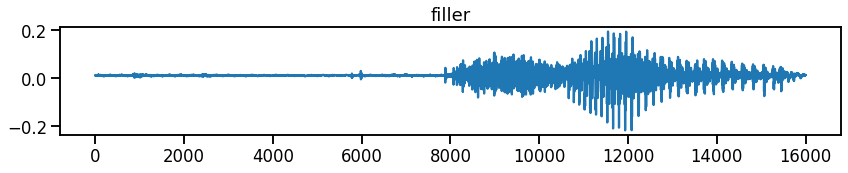

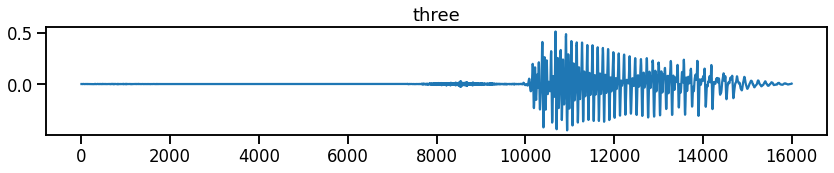

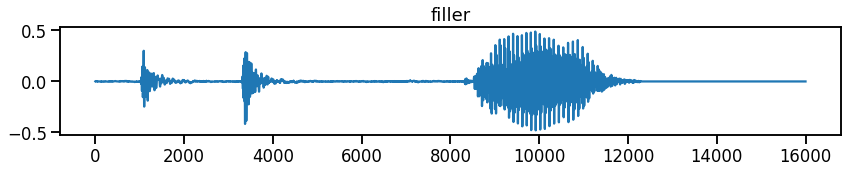

In [15]:
#Display and listen to some of the waveforms
for s in X_train[:3]:
    _ = plt.figure(figsize=(14,2))
    plt.plot(decode_audio(s))
    plt.title(output_classes[get_label_int(s, aux_kws, output_classes)])
    plt.show()
    # We can also preview the sound
    display.display(display.Audio(decode_audio(s), rate=16000))

In [17]:
def get_atoms(frames_features, past_frames=23, future_frames=8):
    """
    (NOT USING THIS)
    Gets all the atoms from a full feature matrix... 
    Input: frames_features. rows = time dimension; colums = features"""
    atoms = []

    frames_is = list(range(len(frames_features)))[past_frames:-future_frames]
    for i in frames_is:
        atoms.append(frames_features[i-past_frames:i+future_frames+1])

    return np.array(atoms)

In [18]:
def get_random_atom(frames_features, past_frames=23, future_frames=8, center_crop=False):
    """Extracts random crop from full MFCC feature matrix of an audio file. 
    If center_crop = True, it crops exactly in the middle. Used for validation and test. """
    frames_is = list(range(len(frames_features)))[past_frames:-future_frames]
    if center_crop:
        # perform a crop in the middle
        crop_len = past_frames+future_frames+1

        l_space = int((len(frames_features)-crop_len)/2)
        return frames_features[l_space:l_space+crop_len]
    else:
        choice = np.random.choice(frames_is)
        return frames_features[choice-past_frames:choice+future_frames+1]

In [19]:
# atoms = get_atoms(test_mfcc)
# fig, axes = plt.subplots(1,3, figsize=(14,5))
# axes[0].imshow(get_random_atom(test_mfcc, past_frames=23, future_frames=8, center_crop=False).numpy().T)
# axes[1].imshow(get_random_atom(test_mfcc, past_frames=23, future_frames=8, center_crop=False).numpy().T)
# axes[2].imshow(get_random_atom(test_mfcc, past_frames=23, future_frames=8, center_crop=False).numpy().T)
# plt.suptitle("Different crops from full feature matrix")
# plt.show()
# print(atoms.shape)

In [20]:
# get_random_atom(test_mfcc, past_frames=23, future_frames=8, center_crop=True)

## Create tf.Dataset of waveforms

In [21]:
def preprocess(file_name, label):
    return decode_audio(file_name), label

def create_dataset(files_ds, 
                   labels,
                   batch_size,
                   shuffle=False,
                   cache_file=None):
    dataset = tf.data.Dataset.from_tensor_slices((files_ds, labels))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    #Cache dataset
    if cache_file:
        dataset.cache(cache_file)
        
    #Shuffle dataset
    if shuffle:
        dataset = dataset.shuffle(len(files_ds))
    
    #Repeat dataset indefinitely (useful when len(dataset)/batch_size is not integer. In those cases, reuse data
    #in order to have batches of equal dimension)
    dataset = dataset.repeat()
    
    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset    

In [22]:
# TEST DATASET E MODEL
batch_size = 64

smoke_size = 0

if smoke_size > 0:
    names_train = X_train[:smoke_size]
    labels_train = y_train[:smoke_size]
    names_valid = X_valid[:int(smoke_size/10)]
    labels_valid = y_valid[:int(smoke_size/10)]
else:
    names_train = X_train
    labels_train = y_train
    names_valid = X_valid
    labels_valid = y_valid
    names_test = X_test
    labels_test= y_test
    

train_dataset = create_dataset(names_train,
                               labels_train, 
                               batch_size=batch_size, 
                               shuffle=False,
                               cache_file='train_cache')

valid_dataset = create_dataset(names_valid,
                             labels_valid,
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache')

test_dataset = create_dataset(names_test,
                             labels_test,
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='test_cache')

train_steps = int(np.ceil(len(names_train)/batch_size))
valid_steps = int(np.ceil(len(names_valid)/batch_size))
test_steps = int(np.ceil(len(names_test)/batch_size))
print(f"Train steps: {train_steps}")
print(f"Validations steps: {valid_steps}")
print(f"Test steps: {test_steps}")


for i in train_dataset.take(1):
    print("Example of dataset element:")
    print(i)

Train steps: 1323
Validations steps: 166
Test steps: 166
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 1.1566162e-02,  1.2268066e-02,  1.3458252e-02, ...,
         1.1230469e-02,  1.1749268e-02,  1.3153076e-02],
       [ 2.4414062e-04,  3.3569336e-04,  9.1552734e-05, ...,
         3.2958984e-03,  3.6315918e-03,  3.6315918e-03],
       [ 1.0681152e-03,  2.4719238e-03,  2.9296875e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.2512207e-03, -2.1362305e-03, -1.8615723e-03, ...,
         2.9296875e-03,  3.3264160e-03,  3.0822754e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.4414062e-04,  9.1552734e-05,  1.8310547e-04],
       [-1.2207031e-04, -1.5258789e-04, -6.1035156e-05, ...,
         3.9672852e-04,  3.6621094e-04,  3.0517578e-04]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([20, 13, 20, 10,  5,  9, 11, 14, 13, 12, 20,  6, 11, 20, 13,  5, 20,
   

2021-08-15 22:29:32.622887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-15 22:29:32.642507: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


## Extraction of cepstral coefficients

TODO: to review... we explain here how to compute MFCCs.
How many frames are created from a wave?
Assume we use 25ms windows, distantiated by 10ms. We are using a sample rate of 16kHz, therefore 25ms are 400 samples, and 10ms are 160 samples. We keep framing until the end of the speech signal. 

If $n$ is the total number of samples, $w$ is the frame width and $s$ is the time step, then the total number of obtained frames is:

$$x = \frac{n-w}{s}+1 $$

If that fraction isnt a natural number, we zero pad the signal (automatically done by the library).

In [23]:
import librosa.display
import librosa as lr

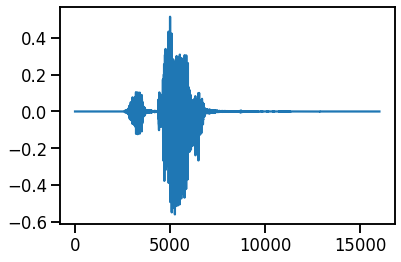

In [24]:
test_wave = decode_audio(X_train[1011])
plt.plot(test_wave)
plt.show()

In [29]:
test_waves = tf.stack([decode_audio(X_train[1010]), decode_audio(X_train[1011])])

In [30]:
test_waves

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[-5.7983398e-03, -6.2561035e-03, -4.3334961e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.1035156e-05,  6.1035156e-05,  1.2207031e-04, ...,
        -1.5258789e-04, -1.5258789e-04, -2.4414062e-04]], dtype=float32)>

In [31]:
_SAMPLE_RATE = 16000
_FFT_SIZE = 512 #determines the number of frequency bins (which is fft_size/2 + 1)
_FRAME_SIZE = 400 #frame length: this value determines the tradeoff between time vs frequency resolution
_HOP_SIZE = 160 #hop size
_N_MEL_BINS = 26 #numero di filtri
_N_SPECTROGRAM_BINS = (_FFT_SIZE // 2) + 1
_F_MIN = 0.0
_F_MAX = _SAMPLE_RATE / 2

In [32]:
spectrogram = tf.signal.stft(test_wave, 
                              frame_length=_FRAME_SIZE, 
                              frame_step=_HOP_SIZE)
spectrogram =  tf.abs(spectrogram)
# spectrogram=tf.multiply(tf.math.square(spectrogram), 1/_FFT_SIZE)
spectrogram

2021-08-15 18:54:11.589496: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10


<tf.Tensor: shape=(98, 257), dtype=float32, numpy=
array([[2.48498982e-05, 3.55134427e-04, 1.05682167e-03, ...,
        1.49251282e-04, 2.17348919e-04, 2.40181340e-04],
       [3.42174579e-04, 4.78521950e-04, 8.06592579e-04, ...,
        1.15498544e-04, 6.30342111e-05, 6.39068021e-05],
       [1.94534124e-03, 2.01500230e-03, 2.02549458e-03, ...,
        5.59515465e-05, 5.17643712e-05, 9.37393634e-06],
       ...,
       [4.67813108e-03, 4.98595648e-03, 5.47999982e-03, ...,
        5.66934032e-05, 9.51609836e-05, 6.23550732e-05],
       [4.64357901e-03, 4.60147113e-03, 4.58057411e-03, ...,
        9.26193679e-05, 1.14451417e-04, 8.37256666e-05],
       [4.69113933e-03, 1.96930859e-03, 3.64474929e-03, ...,
        1.07492902e-04, 7.66800295e-05, 5.17596454e-05]], dtype=float32)>

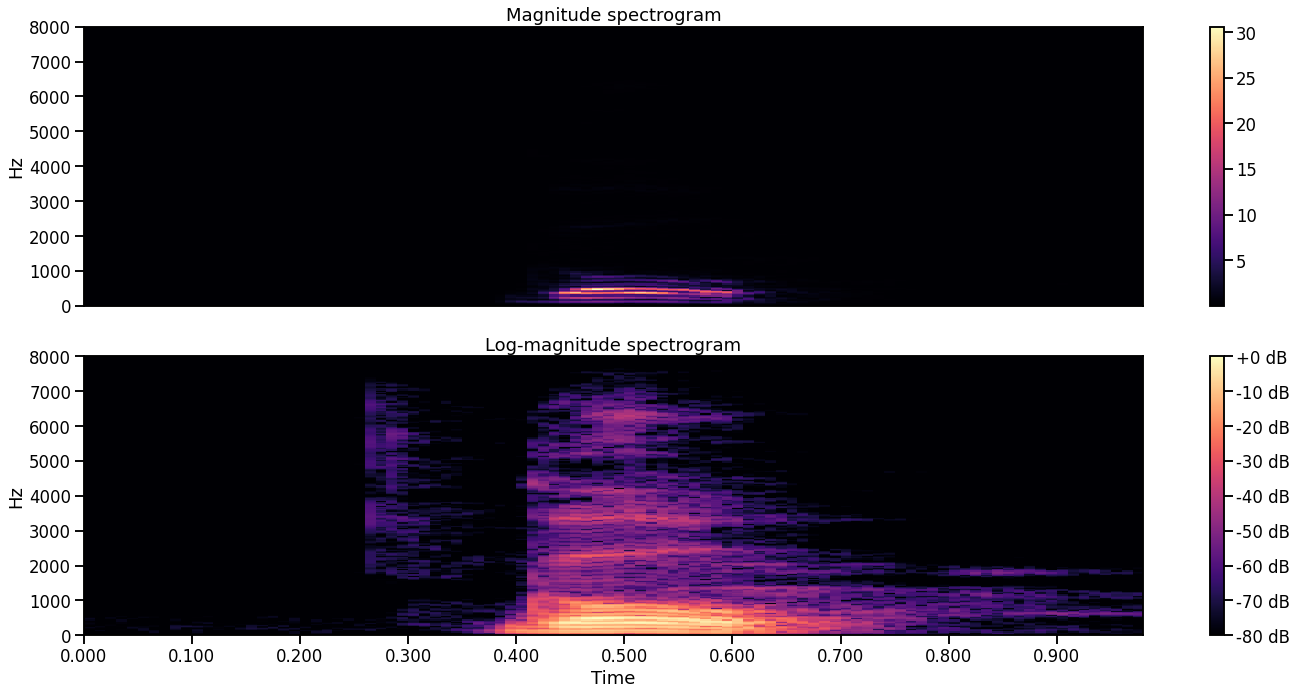

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
lr.display.specshow(spectrogram.numpy().T, sr=_SAMPLE_RATE, y_axis='linear')
plt.colorbar()
plt.title('Magnitude spectrogram')

plt.subplot(2, 1, 2)
lr.display.specshow(lr.amplitude_to_db(spectrogram.numpy().T, ref=np.max),
                    y_axis='linear', x_axis='time', sr=_SAMPLE_RATE, 
                    hop_length=_HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram')
plt.tight_layout()
# _ = plt.savefig('magspec.png', dpi=300)

We now convert the spectrogram from hertz to mel scale. The mapping is done by `tf.signal.linear_to_mel_weight_matrix()` function, which defines the mel scale according to the following formula:

$$ \operatorname{mel}(f)=2595 * \log _{10}\left(1+\frac{f}{700}\right) $$

In [34]:
# Warp the linear scale spectrograms into the mel-scale.
# spectrogram=tf.multiply(tf.math.square(spectrogram), 1.0/_FFT_SIZE)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=_N_MEL_BINS,
    num_spectrogram_bins=_N_SPECTROGRAM_BINS,
    sample_rate=_SAMPLE_RATE,
    lower_edge_hertz=_F_MIN,
    upper_edge_hertz=_F_MAX)
print(linear_to_mel_weight_matrix.shape)

(257, 26)


In [35]:
mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
# mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
#   linear_to_mel_weight_matrix.shape[-1:]))

2021-08-15 18:54:13.375978: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-15 18:54:13.627348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [36]:
mel_spectrograms
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
log_mel_spectrograms

<tf.Tensor: shape=(98, 26), dtype=float32, numpy=
array([[-6.0014896, -5.1828756, -4.686145 , ..., -4.389436 , -4.5758   ,
        -5.1824117],
       [-5.5556726, -4.7815127, -4.667908 , ..., -4.41061  , -4.478993 ,
        -5.0317593],
       [-5.330831 , -5.465502 , -5.191005 , ..., -4.4028935, -4.205643 ,
        -4.852971 ],
       ...,
       [-4.415304 , -4.081155 , -4.632995 , ..., -4.1707945, -4.1844087,
        -4.8446894],
       [-4.5667515, -4.479049 , -4.593468 , ..., -4.2692738, -4.2450395,
        -4.928993 ],
       [-4.736165 , -4.6033616, -5.4610677, ..., -4.32825  , -4.212592 ,
        -4.9549975]], dtype=float32)>

In [37]:
#NOW compute MFCCs from log-magnitude mel scaled spectrogram
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)
mfccs = mfccs[:,:13]
mfccs

<tf.Tensor: shape=(98, 13), dtype=float32, numpy=
array([[-37.276672  ,  -0.72102493,   1.2918906 , ...,  -0.17393152,
          0.16301574,  -0.15637149],
       [-36.696907  ,  -1.5354981 ,   0.99566936, ...,  -0.30138454,
         -0.26633117,  -0.29019135],
       [-37.16395   ,  -1.0252374 ,   1.1830736 , ...,   0.17580508,
          0.11865186,  -0.17041548],
       ...,
       [-30.93359   ,   1.7461878 ,  -0.19720264, ...,   0.12067673,
          0.2798503 ,  -0.90463406],
       [-30.909176  ,   1.203391  ,  -0.5942676 , ...,  -0.21464251,
          0.40764198,  -0.5785796 ],
       [-31.784174  ,   1.2643809 ,  -0.61398965, ...,   0.3710116 ,
          0.4969438 ,  -0.4935755 ]], dtype=float32)>

LIFTERING
https://dsp.stackexchange.com/questions/63505/understanding-liftering-as-the-final-step-in-mfccs-features-extraction

https://maxwell.ict.griffith.edu.au/spl/publications/papers/euro99_kkp_fbe.pdf

lifter source code: https://github.com/jameslyons/python_speech_features/blob/e280ac2b5797a3445c34820b0110885cd6609e5f/python_speech_features/base.py#L179

In [38]:
from python_speech_features import lifter

In [39]:
def tf_lift(mfccs, L=22):
    n = tf.range(mfccs.shape[1], dtype=tf.float32)
    lift = 1.0 + (L/2.0)*tf.math.sin(np.pi*n/L)
    print(mfccs.shape, lift.shape)
    return mfccs * lift

(98, 13) (13,)
(98, 13)


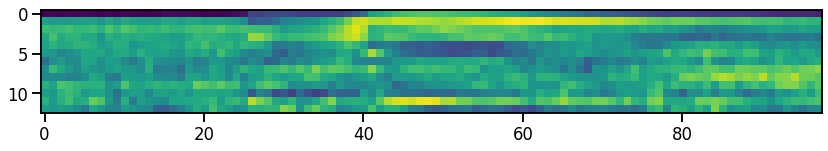

In [40]:
plt.figure(figsize=(14,10))
n_mfccs = tf_lift(mfccs, 30)
plt.imshow(n_mfccs.numpy().T)
print(mfccs.shape)
# plt.colorbar()
plt.show()

Produces very similar result to the python_speech_features library..

(99, 13)


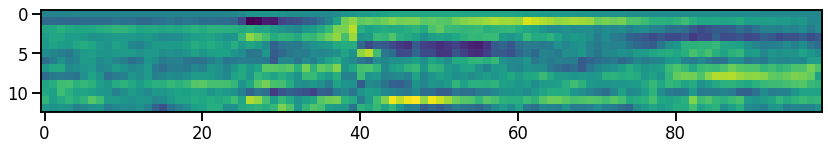

In [41]:
cc = mfcc(decode_audio(X_train[1011]), samplerate=_SAMPLE_RATE, winlen=0.025, winstep=0.01, numcep=13, nfilt=_N_MEL_BINS, lowfreq=_F_MIN, highfreq=_F_MAX)
plt.figure(figsize=(14,10))
print(cc.shape)
plt.imshow(cc.T)
# plt.colorbar()
plt.show()

## MFCC custom layer and LogMelSpectrogram custom layer

In [42]:
layer0 = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26)

In [45]:
log_mel_sp = layer0(tf.expand_dims(decode_audio(X_train[0]), 0))

In [ ]:
layer = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26, n_cepstral=13)

In [ ]:
layer(tf.expand_dims(decode_audio(X_train[0]), 0))

### Stacking audio frames
To obtain the actual inputs for our NN models we have to stack feature vectors of the frames in order to obtain past and future context. We call this stacked vectors an *atom*.
Specifically we use $p=23$ frames for past context and $f=8$ for future context, for a total of 32 frames.
Note that if we stack $k$ frames, each of which is $w$ seconds long, and are distantiated by steps of $s$ seconds, then the total length in seconds of the atom is:

$$l = (k-1)s + w$$

And the total number of atoms which can be extracted from a single file is:

$$ y = n - p - f $$ where $n$ is the total number of frames.

In our case $y=68$.

In [46]:
#TODO

## Test CNN model

In [25]:
def SimpleCNN_2(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
#     norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
#     norm_layer.adapt(ds.map(lambda x,_: x[0]))
    
    X_input = tf.keras.Input(input_shape)
    X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
#     X = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26, n_cepstral=13)(X_input)
#     X = tf.keras.layers.experimental.preprocessing.Resizing(64,64)(X_input)
#     X = norm_layer(X)
    X = layers.Conv2D(32, 3)(X)
#     X = layers.BatchNormalization(axis=-1)(X)
    X = layers.Activation('relu')(X)
#     X = layers.Conv2D(64, 3)(X)
#     X = layers.BatchNormalization(axis=-1)(X)
#     X = layers.Activation('relu')(X)
#     X = layers.MaxPooling2D()(X)
    X = layers.Dropout(0.25)(X)
    X = layers.Flatten()(X)
    X = layers.Dense(256, activation='relu')(X)
    X = layers.Dense(len(output_classes))(X)
    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='SimpleCNN')
    return model

model2 = SimpleCNN_2(train_dataset)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [26]:
EPOCHS = 10
history = model2.fit(
    train_dataset, 
    validation_data=valid_dataset,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    steps_per_epoch=train_steps,
    validation_steps=valid_steps
)

Epoch 1/10


2021-08-15 22:29:58.800664: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-15 22:29:58.893804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-15 22:29:59.150690: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-15 22:29:59.151135: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-15 22:29:59.460740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


1323/1323 [==============================] - 31s 22ms/step - loss: 1.7224 - accuracy: 0.4766 - val_loss: 1.3065 - val_accuracy: 0.5889
Epoch 2/10
1323/1323 [==============================] - 29s 22ms/step - loss: 1.0798 - accuracy: 0.6614 - val_loss: 1.0584 - val_accuracy: 0.6803
Epoch 3/10
1323/1323 [==============================] - 29s 22ms/step - loss: 0.8685 - accuracy: 0.7276 - val_loss: 0.9737 - val_accuracy: 0.7090
Epoch 4/10
1323/1323 [==============================] - 28s 21ms/step - loss: 0.7507 - accuracy: 0.7635 - val_loss: 0.9594 - val_accuracy: 0.7150
Epoch 5/10
1323/1323 [==============================] - 29s 22ms/step - loss: 0.6649 - accuracy: 0.7896 - val_loss: 0.9626 - val_accuracy: 0.7242
Epoch 6/10
1323/1323 [==============================] - 26s 20ms/step - loss: 0.6032 - accuracy: 0.8076 - val_loss: 0.9392 - val_accuracy: 0.7345
Epoch 7/10
1323/1323 [==============================] - 26s 20ms/step - loss: 0.5468 - accuracy: 0.8254 - val_loss: 0.9264 - val_accura

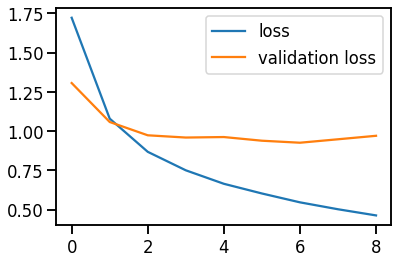

In [27]:
# GPU WORKS NOW!!! cpu not a bottleneck anymore 
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'validation loss'])
plt.show()

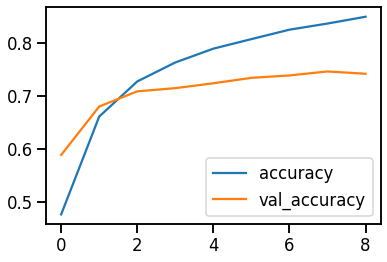

In [28]:
plt.plot(history.epoch,  metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [29]:
y_pred = model2.predict(test_dataset, steps=test_steps)[:len(y_test)]
y_pred = np.array(np.argmax(y_pred, axis=1))
y_true = np.array(y_test)

Test set accuracy: 75.132%


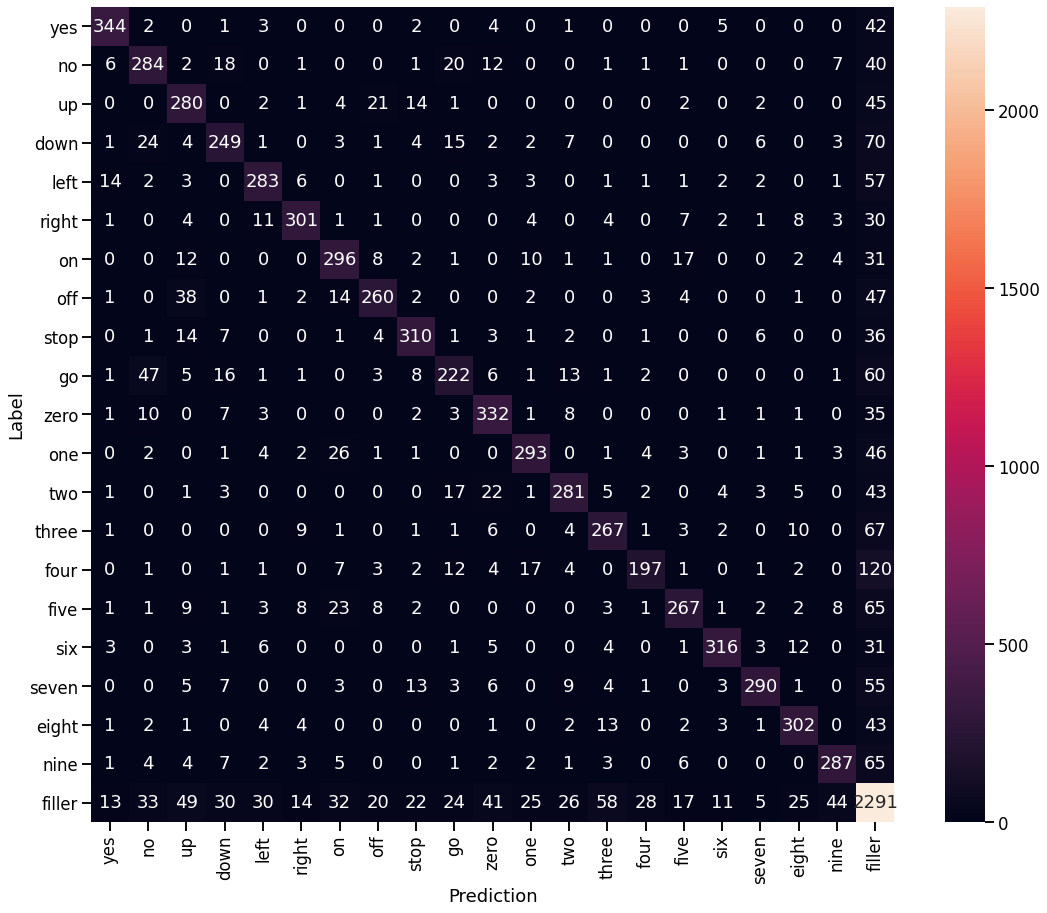

In [30]:
sns.set_context("talk")

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(18, 15))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [62]:
np.unique(y_pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([433, 412, 371, 396, 278, 459, 382, 390, 321, 375, 402, 387, 393,
        390, 351, 386, 361, 384, 443, 446, 373]))